# LSTM Model

## Imports

In [2]:
!pip install --upgrade tensorflow

^C


In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd

## Step 1: Load data

In [2]:
ticker = 'MSFT'
with open(f'../DataInputs/Weekly-Closing-prices/{ticker}_Pricing/{ticker}_weekly_close.json', 'r') as file:
    data = json.load(file)

# Convert data to a sorted list of tuples (date, price)
sorted_data = sorted((pd.to_datetime(date), float(price)) for date, price in data.items())

# Separate dates and prices
dates, prices = zip(*sorted_data)


## Step 2: Preprocess data

In [3]:
# reshaping the array to 2D as required by the scaler
prices = np.array(prices).reshape(-1, 1)

# Normalize prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)


## Step 3: Split the data

In [4]:
# Split data into training and testing sets
# train_data, test_data = train_test_split(scaled_prices, test_size=0.2, shuffle=False)
# make this dynamic, as in being able to choose the date range or manually split the data my self


import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assume dates and scaled_prices are already defined
# Convert dates list to pandas datetime for easier handling
dates_pd = pd.to_datetime(dates)

# Define your split date
split_date = pd.Timestamp('2022-04-08')

# Define your end date
end_date = pd.Timestamp('2022-07-01')  # End date for the dataset

# Find the index to start the split
split_start_index = np.where(dates_pd >= split_date)[0][0]

# Find the index to end the split, ensuring the end_date is included in the test set
split_end_index = np.where(dates_pd > end_date)[0][0]

print("Split Date Index:", split_start_index)
print("End Date Index:", split_end_index)

if split_end_index.size == 0:
    print(f"No matching end date found for {end_date}.")
elif split_start_index.size == 0:
    print(f"No matching split date found for {split_date}.")
elif split_end_index <= split_start_index:
    print("End index is not after the start index. No data in test set.")
else:
    print("Indices found. Proceeding with data split.")
    # Continue with the data split as normal


# Split scaled_prices using the found indices
# Training data goes from the beginning to the split_start_index
train_data = scaled_prices[:split_start_index]

# Testing data goes from split_start_index to split_end_index
# This ensures that the test data starts from split_date and ends at end_date
test_data = scaled_prices[split_start_index:split_end_index]

# Now your train_data and test_data are correctly split based on the dates
# Proceed with the rest of your LSTM preparation and training as before

print(test_data.shape)
print(train_data.shape)


Split Date Index: 1169
End Date Index: 1182
Indices found. Proceeding with data split.
(13, 1)
(1169, 1)


## Step 4: Prepare data for LSTM

In [5]:
# Create training and testing datasets
# def create_dataset(data, time_step=1):
#     X, Y = [], []
#     for i in range(len(data) - time_step - 1):
#         a = data[i:(i + time_step), 0]
#         X.append(a)
#         Y.append(data[i + time_step, 0])
#     return np.array(X), np.array(Y)


def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step)]  # Corrected slicing for 1D array
        X.append(a)
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)



In [6]:

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1167, 1, 1)
X_test shape: (11, 1, 1)


In [7]:

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


## Step 5: Build the LSTM model

In [8]:

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Step 6: Train the model

In [9]:

model.fit(X_train, y_train, batch_size=1, epochs=10)


Epoch 1/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0070
Epoch 2/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.3531e-04
Epoch 3/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.1761e-04
Epoch 4/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.2893e-04
Epoch 5/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.5772e-04
Epoch 6/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.8378e-04
Epoch 7/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.9250e-04
Epoch 8/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.3934e-04
Epoch 9/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.2126e-04
Epoch 10/10
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.5531e-04


In [10]:

# Prepare the initial state from the end of the training set
last_train_batch = train_data[-time_step:]
last_train_batch = last_train_batch.reshape((1, time_step, 1))

In [11]:

# Generate predictions on the test data
test_predictions = []

# Start at the beginning of the test_data and iterate over it to make predictions
for i in range(len(test_data) - time_step):
    # Reshape the input for the model to make a prediction
    current_batch = test_data[i:(i + time_step), 0]
    current_batch = current_batch.reshape((1, time_step, 1))
    
    # Get the prediction (only one at each step) and store it
    test_pred = model.predict(current_batch)[0]
    test_predictions.append(test_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [12]:

# Flatten the test_predictions list and scale back to original values
test_predictions = np.array(test_predictions).reshape(-1, 1)
test_predictions = scaler.inverse_transform(test_predictions)

# Calculate the starting index for plotting test predictions
test_start_index = len(train_data) + time_step

print("test_start_index:", test_start_index)

# Ensure that we have the same number of dates as test predictions for plotting
plot_dates = dates[test_start_index:test_start_index + len(test_predictions)]


test_start_index: 1170


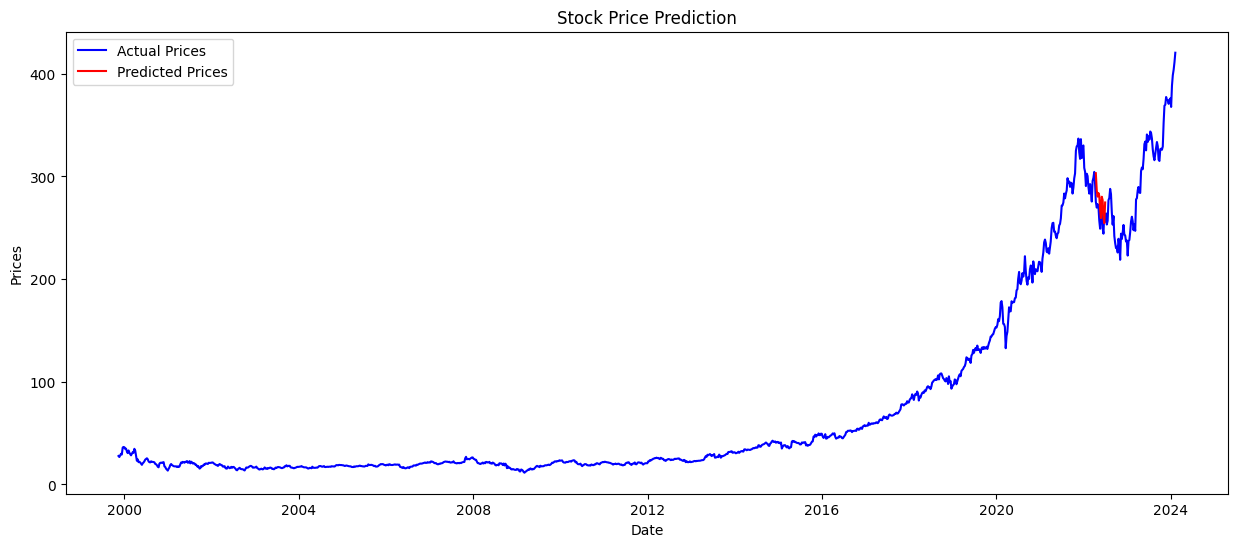

In [13]:
# After generating your predictions and actual prices

# Flatten the test_predictions if they're not already flat
test_predictions = np.array(test_predictions).reshape(-1)

# Generate a list of plot dates that matches the length of your test predictions
# This assumes that 'test_start_index' is the index where test data starts
plot_dates = dates[test_start_index:test_start_index + len(test_predictions)]

# Now plot the data
plt.figure(figsize=(15, 6))

# Plot the entire dataset for actual prices
plt.plot(dates, prices, label='Actual Prices', color='blue')

# Plot the predicted prices
# Make sure plot_dates and test_predictions have the same length
plt.plot(plot_dates, test_predictions, label='Predicted Prices', color='red')

plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()


## RMSE & MAE

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Since we have already scaled the test data and predicted data, we need to inverse the scaling to get meaningful error metrics
actual_test_prices = scaler.inverse_transform(test_data[time_step:])
predicted_test_prices = test_predictions

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(actual_test_prices, predicted_test_prices))
mae = mean_absolute_error(actual_test_prices, predicted_test_prices)

print(f'Test RMSE: {rmse}')
print(f'Test MAE: {mae}')


Test RMSE: 18.118919889049316
Test MAE: 16.917943579101557


## Evaluating on specific dates

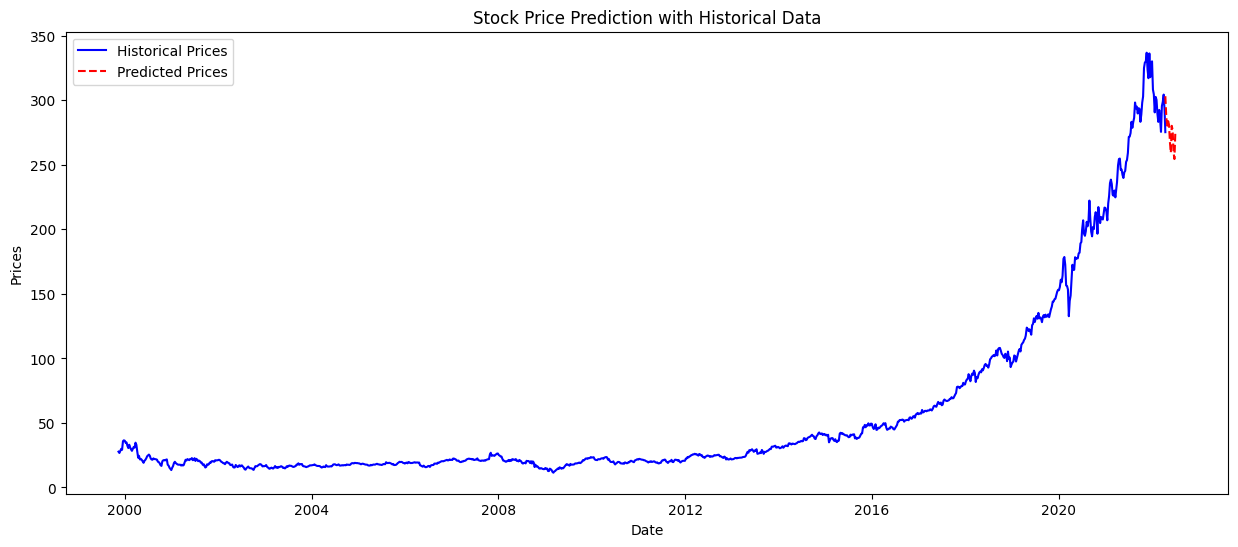

In [15]:
# We need to ensure that plot_dates is a list of pandas Timestamps for correct plotting.
# If plot_dates was not previously converted to Timestamps, you should convert it as follows:
plot_dates = pd.to_datetime(plot_dates)

# Plot the entire prediction period
plt.figure(figsize=(15, 6))

# Plot the actual historical data up to the end of the training data.
# The training data goes up to 'test_start_index', and we'll include the 'time_step' because it's used to generate the first prediction.
plt.plot(dates[:test_start_index+time_step], prices[:test_start_index+time_step], label='Historical Prices', color='blue')

# Now plot the prediction period.
# 'plot_dates' contains the dates corresponding to the prediction period, which comes after the historical data.
plt.plot(plot_dates, test_predictions, label='Predicted Prices', color='red', linestyle='--')

plt.title('Stock Price Prediction with Historical Data')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()


Saving results

In [16]:
import os
import json

# Define the directory path based on your ticker and event
output_dir = f'../outputs/{ticker}/drop'

# Ensure the directory exists; if not, create it
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the full path for the JSON file
output_file_path = os.path.join(output_dir, f'LSTM_prediction.json')

# Convert your predictions to a list (if not already)
# Assuming test_predictions is your predictions array after inverse scaling
predictions_list = test_predictions.flatten().tolist()

# Create a dictionary to store dates as keys and predictions as values
# Ensure plot_dates is a list of strings representing dates
prediction_dates = [date.strftime('%Y-%m-%d') for date in plot_dates]
predictions_dict = dict(zip(prediction_dates, predictions_list))

# Save the predictions to a JSON file
with open(output_file_path, 'w') as file:
    json.dump(predictions_dict, file, indent=4)

print(f'Predictions saved successfully to {output_file_path}')


Predictions saved successfully to ../outputs/MSFT/drop\LSTM_prediction.json
